<a href="https://colab.research.google.com/github/Simsonsg/ARI3212-Advanced-Reinforcement-Learning/blob/main/Experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Apply Standard DQN to LunarLander-v3

In [1]:
!pip -q install gymnasium[box2d]
!pip -q install renderlab
!apt-get install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 2 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (7,517 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../swig4.0_

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 10000
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.995  # per-episode decay
TARGET_UPDATE_FREQ = 10  # update target network every N episodes
MAX_EPISODES = 2000
SOLVE_SCORE = 195.0

In [4]:
env = gym.make("LunarLander-v3", render_mode="rgb_array") #init environment with default params
obs, info = env.reset()
episode_reward = 0.0

In [19]:
experience = namedtuple('Transition', ['states', 'actions', 'rewards', 'dones', 'next_states'])

class replay_memory():
  def __init__(self, env, fullsize, minsize, batchsize):
    self.env = env
    self.memory = deque(maxlen=fullsize)
    self.rewards = deque(maxlen=50)
    self.batchsize = batchsize
    self.minsize = minsize

  def append(self, transition):
    self.memory.append(transition)

  def sample_batch(self):
      batch = random.sample(self.memory, self.batchsize)
      batch = experience(*zip(*batch))

      states = torch.from_numpy(np.array(batch.states, dtype=np.float32)).to(device)
      actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1).to(device)
      rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1).to(device)
      dones = torch.from_numpy(np.array(batch.dones, dtype=np.float32)).unsqueeze(1).to(device)  # 1.0 if done else 0.0
      next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32)).to(device)
      return states, actions, rewards, dones, next_states

  def initialize(self):
      obs, info = self.env.reset()
      for _ in range(self.minsize):
          action = self.env.action_space.sample()
          new_obs, reward, terminated, truncated, info = self.env.step(action)
          done = terminated or truncated
          self.append(experience(obs, action, reward, done, new_obs))
          obs = new_obs
          if done:
              obs, info = self.env.reset()
      return self

In [20]:
replay_memory = replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [21]:
states, actions, rewards, done, next_states = replay_memory.sample_batch()

In [ ]:
states  # Transitions ('states', 'actions', 'rewards', 'dones', 'next_states') grouped to separate states, actions, rewards, dones, next_states

tensor([[-2.3214e-01,  4.9224e-01, -5.1335e-01,  ...,  5.0100e-01,
          0.0000e+00,  0.0000e+00],
        [ 1.8355e-01,  1.3863e+00,  5.4228e-01,  ..., -7.9691e-02,
          0.0000e+00,  0.0000e+00],
        [-8.9788e-04,  1.4008e+00, -4.0656e-02,  ..., -2.1116e-02,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 6.9461e-01,  8.1505e-01,  1.1954e+00,  ..., -1.8831e-01,
          0.0000e+00,  0.0000e+00],
        [-1.5330e-01,  1.1941e+00, -6.2789e-01,  ...,  1.7660e-01,
          0.0000e+00,  0.0000e+00],
        [-6.2308e-01,  9.1318e-01, -9.7065e-01,  ...,  3.4602e-01,
          0.0000e+00,  0.0000e+00]], device='cuda:0')

In [22]:
class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, noutputs),
        )

    def forward(self, x):
        return self.net(x)

In [23]:
dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()

DQN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [24]:
loss_fn = nn.SmoothL1Loss()  # Huber loss is often more stable for DQN
learning_rate = 5e-4
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

In [25]:
def epsilon_greedy_policy(epsilon, obs):
    if random.random() <= epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        q = dqn_policy(obs_t)
        return int(torch.argmax(q, dim=1).item())

In [ ]:
obs, info = env.reset(seed=0)
eps_threshold = EPS_START
episode = 1
episode_reward = 0.0

for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    replay_memory.append(experience(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs

    # optimize
    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    qvalues = dqn_policy(b_states).gather(1, b_actions)

    with torch.no_grad():
        max_next_q = dqn_target(b_next_states).max(dim=1, keepdim=True).values
        expected_q = b_rewards + GAMMA * (1.0 - b_dones) * max_next_q

    loss = loss_fn(qvalues, expected_q)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(dqn_policy.parameters(), 10.0)
    optimizer.step()

    if done:
        replay_memory.rewards.append(episode_reward)
        avg_res = float(np.mean(replay_memory.rewards))

        if episode % 25 == 0:
            print(f"Episode: {episode:4d} | Avg(50): {avg_res:7.2f} | Epsilon: {eps_threshold:6.3f} | Loss: {loss}")

        if (len(replay_memory.rewards) == replay_memory.rewards.maxlen) and (avg_res >= SOLVE_SCORE):
            print(f"Solved at episode: {episode} | Avg(50): {avg_res:.2f}")
            break

        episode += 1
        if episode > MAX_EPISODES:
            print(f"Stopped at MAX_EPISODES={MAX_EPISODES} | Avg(50): {avg_res:.2f}")
            break

        eps_threshold = max(eps_threshold * EPS_DECAY, EPS_END)
        obs, info = env.reset()
        episode_reward = 0.0

        if episode % TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

Episode:   25 | Avg(50): -161.69 | Epsilon:  0.887
Episode:   50 | Avg(50): -129.12 | Epsilon:  0.782
Episode:   75 | Avg(50):  -94.81 | Epsilon:  0.690
Episode:  100 | Avg(50):  -79.91 | Epsilon:  0.609
Episode:  125 | Avg(50):  -51.63 | Epsilon:  0.537
Episode:  150 | Avg(50):  -30.35 | Epsilon:  0.474
Episode:  175 | Avg(50):  -36.57 | Epsilon:  0.418
Episode:  200 | Avg(50):  -45.08 | Epsilon:  0.369
Episode:  225 | Avg(50):  -20.38 | Epsilon:  0.325
Episode:  250 | Avg(50):  -10.40 | Epsilon:  0.287
Episode:  275 | Avg(50):   -9.14 | Epsilon:  0.253
Episode:  300 | Avg(50):   16.70 | Epsilon:  0.223
Episode:  325 | Avg(50):   27.84 | Epsilon:  0.197
Episode:  350 | Avg(50):   26.51 | Epsilon:  0.174
Episode:  375 | Avg(50):   55.85 | Epsilon:  0.153
Episode:  400 | Avg(50):   94.69 | Epsilon:  0.135
Episode:  425 | Avg(50):  144.74 | Epsilon:  0.119
Episode:  450 | Avg(50):  179.28 | Epsilon:  0.105
Episode:  475 | Avg(50):  179.54 | Epsilon:  0.093
Episode:  500 | Avg(50):  181.3

In [ ]:
import renderlab as rl

# Wrap env to record frames for a short rollout
video_env = gym.make("LunarLander-v3", render_mode="rgb_array")
video_env = rl.RenderFrame(video_env, "./video")

In [ ]:
obs, info = video_env.reset()

while True:
    with torch.no_grad():
        obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        action = int(torch.argmax(dqn_policy(obs_t), dim=1).item())

    obs, reward, terminated, truncated, info = video_env.step(action)
    if terminated or truncated:
        break

video_env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


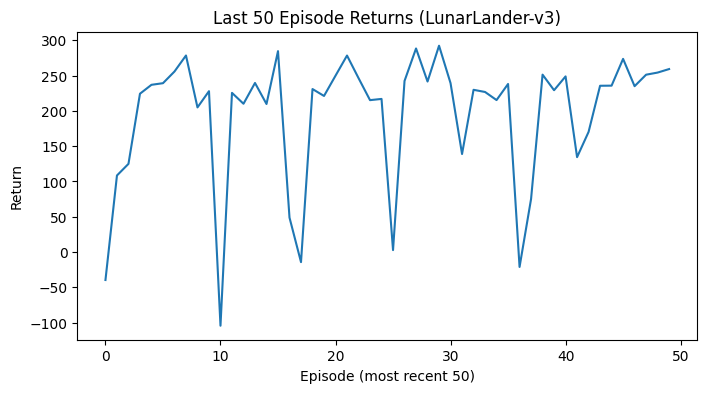

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(list(replay_memory.rewards))
plt.title("Last 50 Episode Returns (LunarLander-v3)")
plt.xlabel("Episode (most recent 50)")
plt.ylabel("Return")
plt.show()

## Applying Double DQN to LunarLander-v3

In [26]:
obs, info = env.reset()
eps_threshold = EPS_START
episode = 1
episode_reward = 0.0

for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    replay_memory.append(experience(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs

    # optimize
    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    qvalues = dqn_policy(b_states).gather(1, b_actions)

    with torch.no_grad():
       _, next_actions = dqn_policy(b_next_states).max(dim=1, keepdim=True)    # use dqn_policy to get actions in next state
       next_action_values = dqn_target(b_next_states).gather(1, next_actions)  # use dqn_target to get values of actions selected by dqn_policy

       expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * next_action_values


    loss = loss_fn(qvalues, expected_qvalues)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(dqn_policy.parameters(), 10.0)
    optimizer.step()

    if done:
        replay_memory.rewards.append(episode_reward)
        avg_res = float(np.mean(replay_memory.rewards))

        if episode % 25 == 0:
            print(f"Episode: {episode:4d} | Avg(50): {avg_res:7.2f} | Epsilon: {eps_threshold:6.3f} | Loss: {loss}")

        if (len(replay_memory.rewards) == replay_memory.rewards.maxlen) and (avg_res >= SOLVE_SCORE):
            print(f"Solved at episode: {episode} | Avg(50): {avg_res:.2f}")
            break

        episode += 1
        if episode > MAX_EPISODES:
            print(f"Stopped at MAX_EPISODES={MAX_EPISODES} | Avg(50): {avg_res:.2f}")
            break

        eps_threshold = max(eps_threshold * EPS_DECAY, EPS_END)
        obs, info = env.reset()
        episode_reward = 0.0

        if episode % TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

Episode:   25 | Avg(50): -146.17 | Epsilon:  0.887 | Loss: 0.8947734832763672
Episode:   50 | Avg(50): -135.94 | Epsilon:  0.782 | Loss: 1.5693423748016357
Episode:   75 | Avg(50):  -98.85 | Epsilon:  0.690 | Loss: 1.2363147735595703
Episode:  100 | Avg(50):  -72.02 | Epsilon:  0.609 | Loss: 0.884498119354248
Episode:  125 | Avg(50):  -62.31 | Epsilon:  0.537 | Loss: 1.101584792137146
Episode:  150 | Avg(50):  -48.53 | Epsilon:  0.474 | Loss: 0.42835524678230286
Episode:  175 | Avg(50):  -38.03 | Epsilon:  0.418 | Loss: 0.4967852234840393
Episode:  200 | Avg(50):  -37.93 | Epsilon:  0.369 | Loss: 1.341377854347229
Episode:  225 | Avg(50):  -37.01 | Epsilon:  0.325 | Loss: 1.5679945945739746
Episode:  250 | Avg(50):  -21.44 | Epsilon:  0.287 | Loss: 1.5122181177139282
Episode:  275 | Avg(50):   -2.11 | Epsilon:  0.253 | Loss: 0.5249425172805786
Episode:  300 | Avg(50):    6.29 | Epsilon:  0.223 | Loss: 0.5977116823196411
Episode:  325 | Avg(50):   16.86 | Epsilon:  0.197 | Loss: 0.44476

In [ ]:
env = rl.RenderFrame(env, "./video")

In [ ]:
obs, info = env.reset()

while True:
  action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
  obs, reward, terminated, truncated, info = env.step(action)

  if terminated or truncated:
    break

env.play()